In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss, roc_curve, roc_auc_score

In [2]:
DATA_PATH = 'Data/'
MODEL_PREDICTIONS_PATH = 'ModelPredictions/'

EVAL_DATASET = 'test.csv'
EVAL_NAME = 'test'
MAX_K = 20

In [3]:
# Download data
import urllib.request

BASE_URL = 'https://urikz-research-docent.s3.us-west-1.amazonaws.com/MovieLensTagPrediction/TagsHoldout/'

os.makedirs(DATA_PATH, exist_ok=True)
for filename in ['dev.asin.csv', 'dev.csv', 'dev.tag.csv', 'test.asin.csv', 'test.tag.csv', 'test.csv', 'tags.csv']:
    urllib.request.urlretrieve(BASE_URL + "Data/" + filename, os.path.join(DATA_PATH, filename))

os.makedirs(MODEL_PREDICTIONS_PATH, exist_ok=True)
# WARNING:Might take a while to load all of the model predictions
# for prefix in ['bos_bert', 'docent_dual', 'docent_full', 'docent_hybrid']:
for prefix in ['docent_full']:
    for x in [100, 200, 300, 400, 500]:
        if x == 200 and prefix == 'docent_full':
            continue
        filename = '%s_%d.csv' % (prefix , x)
        urllib.request.urlretrieve(BASE_URL + 'ModelPredictions/' + filename, os.path.join(MODEL_PREDICTIONS_PATH, filename))

In [4]:
def load_csv(path, header=0, sep=','):
    df = pd.read_csv(
        path,
        sep=sep,
        keep_default_na=False,
        na_values=[""],
        index_col=False,
        header=header,
    )
    print('--- Loaded %d records from %s' % (len(df), path))
    return df

In [5]:
class MovieVocab(object):
    def __init__(self, data_path, do_lowercase):
        self.do_lowercase = do_lowercase
        df = load_csv(data_path)
        df['asin_normalized'] = df.asin.apply(self._normalize_movie)
        df = df.drop(columns=['asin'])
        df = df.rename(columns={'asin_normalized': 'asin'})        
        self.idx2movie = df.asin.unique()        
        self.movie2idx = dict()
        for idx, movie in enumerate(self.idx2movie):
            self.movie2idx[movie] = idx
        assert len(self.idx2movie) == len(self.movie2idx)
        print('--- Found %d unique movie IDs' % len(self))
    
    def _normalize_movie(self, x):
        if self.do_lowercase:
            return x.lower()
        else:
            return x
    
    def __getitem__(self, movie):
        return self.movie2idx[movie]

    def get_movie_idx_df(self, df, input_column, output_column):
        df_removed = df[~df[input_column].apply(self._normalize_movie).isin(self.idx2movie)]
        if len(df_removed) > 0:
            print('--- WARNING: Filtered out %d items (%d unique movie IDs) with unknown movie ID' % (
                len(df_removed),
                len(df_removed[input_column].unique()),
            ))   
        df = df[df[input_column].apply(self._normalize_movie).isin(self.idx2movie)].copy()            
        df[output_column] = df[input_column].apply(lambda x: self.movie2idx[self._normalize_movie(x)])
        return df              
        
    def __len__(self):
        return len(self.idx2movie)

movie_vocab = MovieVocab(os.path.join(DATA_PATH, EVAL_DATASET), True)

# --- Loaded 141618 records from Data/test.csv
# --- Found 6392 unique movie IDs

--- Loaded 141618 records from Data/test.csv
--- Found 6392 unique movie IDs


In [6]:
class TagVocab(object):
    def __init__(self, data_path):
        self.tag2idx = load_csv(data_path).set_index('tag')
        print('--- Found %d unique tags' % len(self))
        
    def __getitem__(self, tag_str):
        return self.tag2idx.tag_idx[tag_str]
        
    def __len__(self):
        return len(self.tag2idx)

    def _all_tags(self):
        return self.tag2idx.index
    
    def get_tag_idx_df(self, df, input_column, output_column):    
        df[output_column] = df[input_column].apply(lambda x: self[x])
        return df

tag_vocab = TagVocab(os.path.join(DATA_PATH, 'tags.csv'))

# --- Loaded 1128 records from Data/tags.csv
# --- Found 1128 unique tags

--- Loaded 1128 records from Data/tags.csv
--- Found 1128 unique tags


In [7]:
class MovieLens(object):
    def __init__(self, data_path, movie_vocab, tag_vocab):
        df = load_csv(data_path)
        for i, row in df.iterrows():
            assert tag_vocab[row['tag']] == row['tag_idx']
        df = movie_vocab.get_movie_idx_df(df, "asin", "movie_idx")
        self.df = df[['user', 'tag_idx', 'movie_idx']]
        self.movies = np.sort(self.df.movie_idx.unique())
        self.tags = np.sort(self.df.tag_idx.unique())
        self.score = MovieLens.compute_user_score(df, movie_vocab, tag_vocab)
        print('--- MovieLens dataset: %d records, %d unique movies, %d unique tags, %d unique users' % (
            len(self.df), len(self.movies), len(self.tags), len(self.df.user.unique())))

    @staticmethod
    def compute_user_score(df, movie_vocab, tag_vocab):
        score = np.zeros((len(movie_vocab), len(tag_vocab)))
        user_scores = (
            df
            .groupby(['movie_idx', 'tag_idx'])
            .aggregate({'user': 'count'})
            .reset_index())        
        score[user_scores.movie_idx, user_scores.tag_idx] = user_scores.user
        return score
    
movielens = MovieLens(os.path.join(DATA_PATH, EVAL_DATASET), movie_vocab, tag_vocab)

# --- Loaded 141618 records from Data/test.csv
# --- MovieLens dataset: 141618 records, 6392 unique movies, 500 unique tags, 9479 unique users

--- Loaded 141618 records from Data/test.csv
--- MovieLens dataset: 141618 records, 6392 unique movies, 500 unique tags, 9479 unique users


In [8]:
class Model(object):
    def __init__(
        self,
        df,        
        score_column,
        movie_vocab,
        tag_vocab,
        tag_column=None,
        tag_idx_column=None,
        default_value=0,
    ):
        assert bool(tag_column) ^ bool(tag_idx_column)
        print('--- Applying Movie Vocab')
        df = movie_vocab.get_movie_idx_df(df, 'asin', "movie_idx")
        if tag_column is not None:
            print('--- Applying Tag Vocab')            
            df = tag_vocab.get_tag_idx_df(df, tag_column, 'tag_idx')
        self.movies = np.sort(df.movie_idx.unique())
        self.tags = np.sort(df.tag_idx.unique())
        print('--- Creating scores matrix')
        self.score = np.full(
            (len(movie_vocab), len(tag_vocab)), default_value, dtype=np.float32)
        print('--- Building scores matrix')        
        self.score[df.movie_idx, df.tag_idx] = df[score_column]
        print(
            '-- Created a model with %d predictions. '
            'Missing predictions for %d (movie, tag) pairs are using the value %.5f' % (
                len(df),
                len(movie_vocab) * len(tag_vocab) - len(df),
                default_value,
            )
        )

# See https://grouplens.org/datasets/movielens/tag-genome for the TagGenome predictions        
# genome_model = Model(
#     df=load_csv(os.path.join(MODEL_PREDICTIONS_PATH, 'tag_genome.csv')),
#     movie_vocab=movie_vocab,
#     tag_vocab=tag_vocab,
#     score_column='relevance',
#     tag_idx_column='tag_idx',
# )

# --- Loaded 8875104 records from ModelPredictions/tag_genome.csv
# --- Applying Movie Vocab
# --- WARNING: Filtered out 1664928 items (1476 unique movie IDs) with unknown movie ID
# --- Creating scores matrix
# --- Building scores matrix
# -- Created a model with 7210176 predictions. Missing predictions for 0 (movie, tag) pairs are using the value 0.00000

In [9]:
def get_name(path):
    return os.path.split(path)[1][:-len('.csv')]

docent_models = {}

docent_models.update({
    get_name(path): Model(
        df=load_csv(path),
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='score_0',
        tag_idx_column='tag_idx',    
    )
    for path in glob.glob(os.path.join(MODEL_PREDICTIONS_PATH, 'docent_full*.csv'))
})

docent_models.update({
    get_name(path): Model(
        df=load_csv(path),
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='relevance',
        tag_idx_column='tag_idx',    
    )
    for path in glob.glob(os.path.join(MODEL_PREDICTIONS_PATH, 'docent_dual*.csv'))
})

docent_models.update({
    get_name(path): Model(
        df=load_csv(path),
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='relevance',
        tag_idx_column='tag_idx',    
    )
    for path in glob.glob(os.path.join(MODEL_PREDICTIONS_PATH, 'docent_hybrid*.csv'))
})

test_tags = load_csv(os.path.join(DATA_PATH, EVAL_NAME + '.tag.csv')).tag

for path in glob.glob(os.path.join(MODEL_PREDICTIONS_PATH, 'bos_bert*.csv')):
    df = load_csv(path)
    df['tag'] = df.tag_idx.apply(lambda tag_idx: test_tags[tag_idx])
    docent_models[get_name(path)] = Model(
        df=df,
        movie_vocab=movie_vocab,
        tag_vocab=tag_vocab,
        score_column='score_0',
        tag_column='tag',    
    )
                      
docent_models.keys()                      

--- Loaded 3196160 records from ModelPredictions/docent_full_400.csv
--- Applying Movie Vocab
--- WARNING: Filtered out 160 items (1 unique movie IDs) with unknown movie ID
--- Creating scores matrix
--- Building scores matrix
-- Created a model with 3196000 predictions. Missing predictions for 4014176 (movie, tag) pairs are using the value 0.00000
--- Loaded 3196160 records from ModelPredictions/docent_full_500.csv
--- Applying Movie Vocab
--- WARNING: Filtered out 160 items (1 unique movie IDs) with unknown movie ID
--- Creating scores matrix
--- Building scores matrix
-- Created a model with 3196000 predictions. Missing predictions for 4014176 (movie, tag) pairs are using the value 0.00000
--- Loaded 3196160 records from ModelPredictions/docent_full_100.csv
--- Applying Movie Vocab
--- WARNING: Filtered out 160 items (1 unique movie IDs) with unknown movie ID
--- Creating scores matrix
--- Building scores matrix
-- Created a model with 3196000 predictions. Missing predictions for 40

dict_keys(['docent_full_400', 'docent_full_500', 'docent_full_100', 'docent_full_300'])

In [10]:
# tf_idf_model = Model(
#     df=load_csv(os.path.join(MODEL_PREDICTIONS_PATH, 'tf_idf.csv')), 
#     movie_vocab=movie_vocab,
#     tag_vocab=tag_vocab,
#     score_column='score',
#     tag_column='tag',   
#     default_value=-1,
# )      

In [11]:
def intersect_movie_and_tags(models, movies=None, tags=None):
    if movies is None:
        movies = np.arange(len(movie_vocab))
    else:
        movies = np.intersect1d(movies, movielens.movies)
  
    if tags is None:
        tags = np.arange(len(tag_vocab))
    else:
        tags = np.intersect1d(tags, movielens.tags)

    for name, model in models.items():
        movies = np.intersect1d(movies, model.movies)
        tags = np.intersect1d(tags, model.tags)
    
    print('--- Movies %d, Tags %d' % (len(movies), len(tags)))
    return movies, tags

def precision_at_k(binary_labels, num_labels_per_movie, sorted_predictions):
    num_movies = len(num_labels_per_movie)
    counter, precision = np.zeros((num_movies, MAX_K)), np.zeros((num_movies, MAX_K))
    prediction_labels = np.take_along_axis(binary_labels, sorted_predictions, axis=1)
  
    for k_idx in range(MAX_K):
        k = k_idx + 1
        for i in range(len(num_labels_per_movie)):
            if k <= num_labels_per_movie[i]:
                precision[i, k_idx] = prediction_labels[i, :k].mean()
                counter[i, k_idx] = 1
    return precision.sum(axis=0) / (counter.sum(axis=0) + 1e-8)

def set_intersection_at_k(sorted_labels, num_labels_per_movie, sorted_predictions):
    num_movies = len(num_labels_per_movie)
    counter, set_intersection = np.zeros((num_movies, MAX_K)), np.zeros((num_movies, MAX_K))
    for k_idx in range(MAX_K):
        k = k_idx + 1
        for i in range(num_movies):
            if k <= num_labels_per_movie[i]:
                set_intersection[i, k_idx] = (
                    len(np.intersect1d(sorted_labels[i, :k], sorted_predictions[i, :k]))
                    / float(k))
                counter[i, k_idx] = 1
    return set_intersection.sum(axis=0) / (counter.sum(axis=0) + 1e-8)
    
def dcg_at_k_per_movie(labels, predictions, use_log_for_user_counts):
    num_movies = labels.shape[0]
    dcg = np.zeros((num_movies, MAX_K))
    discounts = np.log2(np.arange(2, MAX_K + 2))
    for i in range(num_movies):
        gain = labels[i, predictions[i]]
        if use_log_for_user_counts:
            gain = np.log(gain + 1)        
        for k_idx in range(MAX_K):
            k = k_idx + 1
            dcg[i, k_idx] = np.sum(gain[:k] / discounts[:k])
    return dcg

def ndcg_at_k(labels, predictions, use_log_for_user_counts):
    actual_dcg = dcg_at_k_per_movie(labels, predictions, use_log_for_user_counts)
    ideal_predicitons = np.argsort(-labels, axis=1)
    ideal_dcg = dcg_at_k_per_movie(labels, ideal_predicitons, use_log_for_user_counts)
    ndcg = actual_dcg / (ideal_dcg + 1e-8)
    return ndcg.mean(axis=0)

def eval_model(
    models,
    labels=None,
    groundtruth_threshold=0,
):
    movies, tags = intersect_movie_and_tags(models, movies=None, tags=None)
    assert len(movies) > 0
    assert len(tags) > 0  

    if labels is None:
        labels = movielens.score[movies][:, tags]
    else:
        labels = labels[movies][:, tags]

    labels_flattened = (labels > groundtruth_threshold).reshape(-1)
    binary_labels = labels > groundtruth_threshold
    num_labels_per_movie = binary_labels.sum(axis=1)
    sorted_labels = np.argsort(-movielens.score[movies][:, tags], axis=1)
    movies_with_non_empty_labels = ((labels > groundtruth_threshold).sum(axis=1) > 0)
    num_movies_with_empty_labels = len(movies) - movies_with_non_empty_labels.sum()
    if num_movies_with_empty_labels > 0:
        print('--- WARNING: There are %d movies without any labels (tags): %s' % (
            num_movies_with_empty_labels,
            ','.join([str(i) for i, v in enumerate(movies_with_non_empty_labels) if v == 0])
        ))

    results = {}
    for name, model in models.items():  
        print('--- Model %s' % name)
        scores = model.score[movies][:, tags] 
        scores_flattened = scores.reshape(-1)      

        predictions = np.argsort(-scores, axis=1)
        result = {}
        result["precision@k"] = precision_at_k(
            binary_labels[movies_with_non_empty_labels],
            num_labels_per_movie[movies_with_non_empty_labels],
            predictions[movies_with_non_empty_labels],
        )
        result["set_intersection@k"] = set_intersection_at_k(
            sorted_labels[movies_with_non_empty_labels],
            num_labels_per_movie[movies_with_non_empty_labels],
            predictions[movies_with_non_empty_labels],
        )
        result["label_ranking_loss"] = label_ranking_loss(
            binary_labels[movies_with_non_empty_labels] > 0,
            scores[movies_with_non_empty_labels],
        )
        result["mean_average_precision"] = label_ranking_average_precision_score(
            binary_labels[movies_with_non_empty_labels] > 0,
            scores[movies_with_non_empty_labels],
        )
        result["ndcg_log@k"] = ndcg_at_k(
            labels[movies_with_non_empty_labels],
            predictions[movies_with_non_empty_labels],
            True,
        )
        result["ndcg@k"] = ndcg_at_k(
            labels[movies_with_non_empty_labels],
            predictions[movies_with_non_empty_labels],
            False,
        )
        fpr, tpr, _ = roc_curve(labels_flattened, scores_flattened)
        result["fpr"] = fpr
        result["tpr"] = tpr
        result["auc"] = roc_auc_score(labels_flattened, scores_flattened)

        results[name] = result

    return results, movies, tags

In [12]:
models = {
#     'TagGenome': genome_model,
#     'tf-idf': tf_idf_model,
}
models.update(docent_models)

results_movie_heldout, _, _ = eval_model(
    models=models,
    groundtruth_threshold=2,
)

--- Movies 6392, Tags 500
--- WARNING: There are 3499 movies without any labels (tags): 30,31,123,139,140,160,187,201,215,233,249,265,269,275,284,295,302,316,324,345,349,350,354,371,399,403,422,431,451,454,479,484,485,486,492,493,495,496,505,506,509,514,527,534,535,536,539,573,574,575,628,629,639,641,642,643,645,649,674,679,682,693,695,705,707,719,724,726,733,739,742,743,768,797,816,818,838,844,852,855,911,941,943,951,956,976,1017,1032,1068,1088,1093,1097,1102,1105,1106,1108,1111,1113,1119,1124,1127,1137,1139,1145,1146,1159,1161,1165,1170,1171,1172,1173,1187,1199,1203,1214,1227,1229,1230,1238,1245,1246,1247,1256,1262,1267,1268,1270,1274,1275,1276,1282,1290,1291,1295,1296,1297,1300,1303,1307,1312,1313,1315,1318,1319,1321,1325,1326,1327,1328,1332,1333,1338,1342,1348,1352,1354,1355,1357,1358,1366,1367,1371,1373,1374,1375,1378,1380,1381,1382,1383,1384,1386,1388,1389,1390,1391,1392,1393,1394,1396,1400,1408,1413,1425,1437,1439,1442,1455,1456,1479,1481,1484,1485,1487,1489,1493,1494,1498,1500,

--- Model docent_full_500
--- Model docent_full_100
--- Model docent_full_300


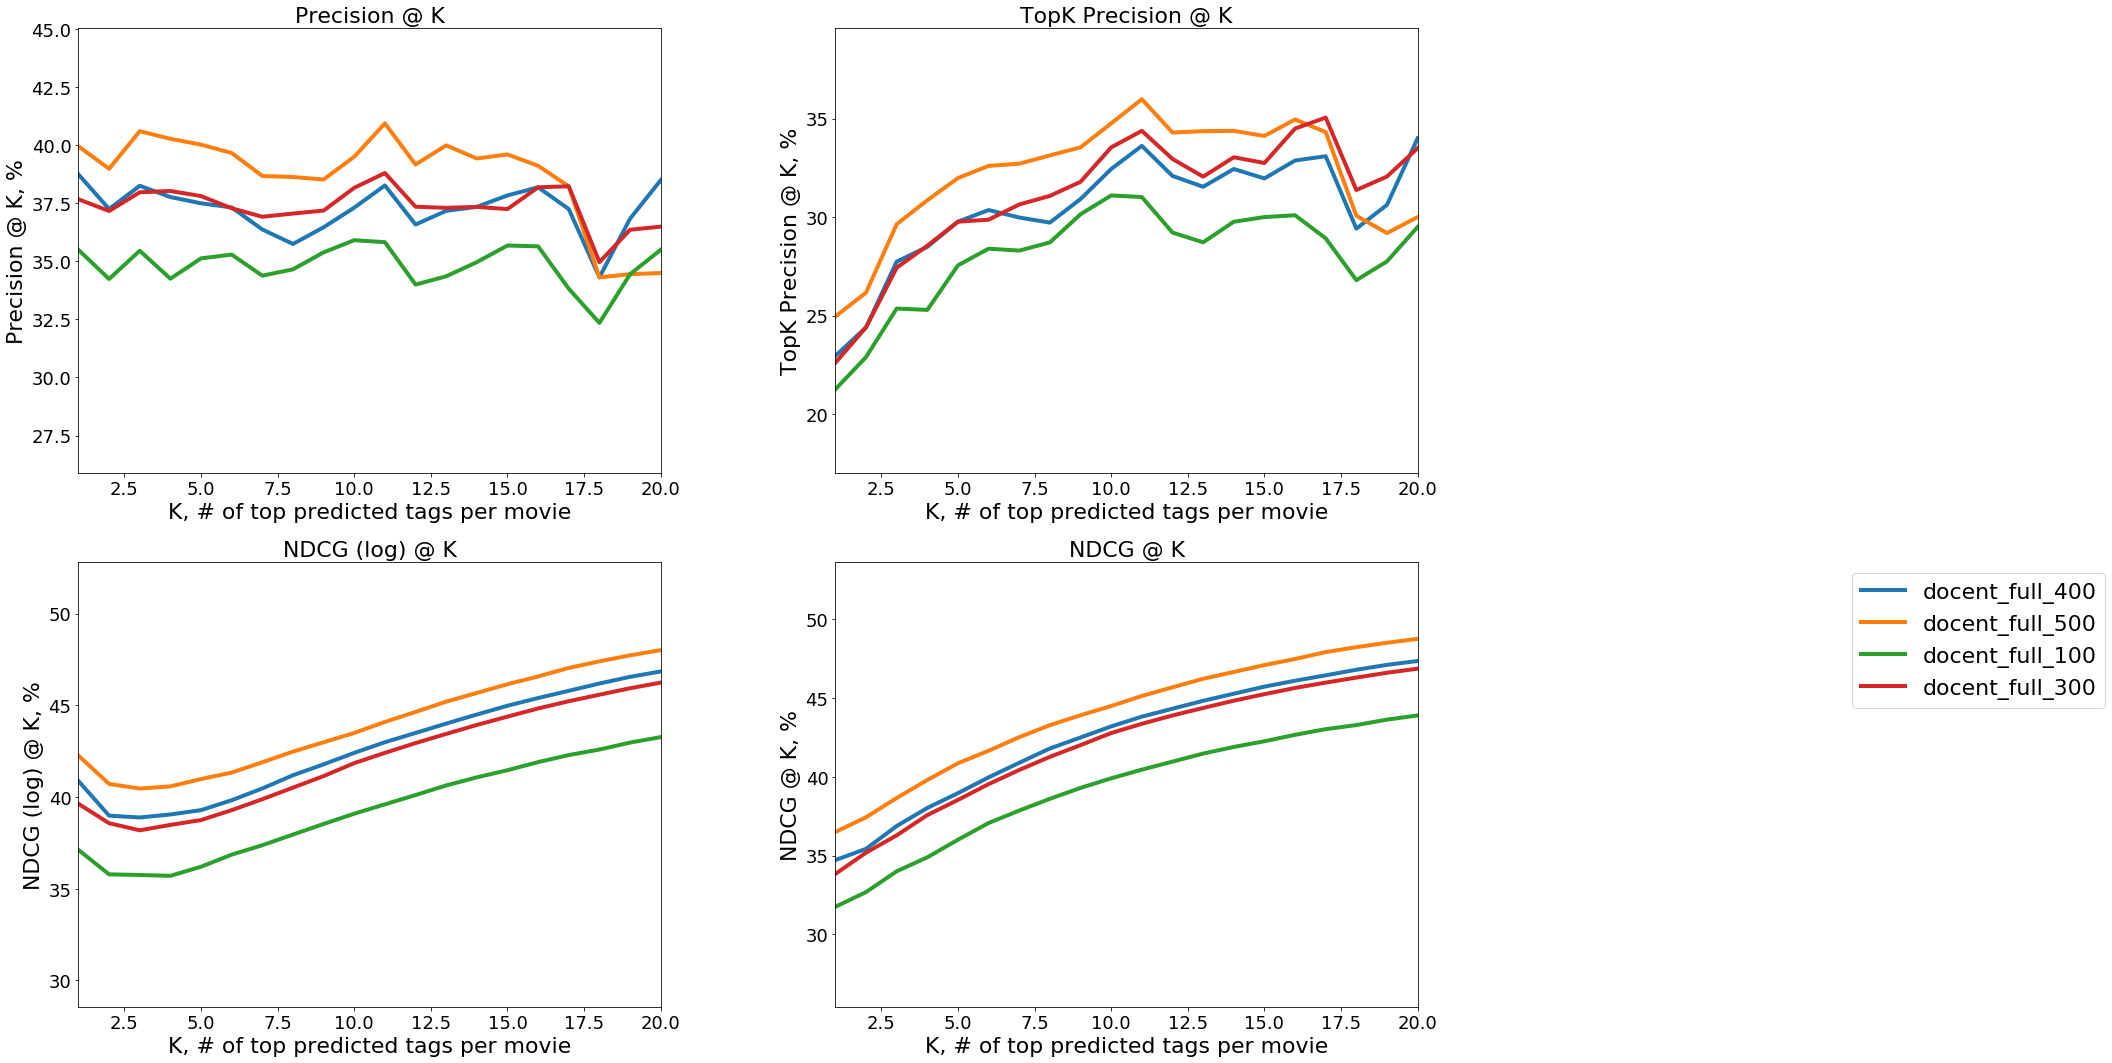

In [13]:
METRIC_LABELS = {
    'precision@k': 'Precision @ K',
    'set_intersection@k': 'TopK Precision @ K',
    'ndcg_log@k': 'NDCG (log) @ K',
    'ndcg@k': 'NDCG @ K',
}

def plot_ranking_results(results):  
    ALL_METRICS = METRIC_LABELS.keys()
    krange = np.arange(1, MAX_K + 1)
    plt.figure(figsize=(24, 18))#, dpi=400)

    for i, metric in enumerate(ALL_METRICS):
        ax = plt.subplot(2, 2, i + 1)
        y_min = min([result[metric].min() for _, result in results.items()])
        y_max = max([result[metric].max() for _, result in results.items()])
        plt.ylim(y_min * 80, y_max * 110)
        plt.xlim(1, MAX_K)
        for name, result in results.items():
            ax.plot(krange, result[metric] * 100.0, label=name, linewidth=4)
            
        plt.title(METRIC_LABELS[metric], fontsize=22)
        plt.ylabel(METRIC_LABELS[metric] + ', %', fontsize=22)
        plt.xlabel('K, # of top predicted tags per movie', fontsize=22)
        for tick in ax.get_xticklabels():
            tick.set_fontsize(18)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(18)
  
    plt.legend(loc='upper right', bbox_to_anchor=(2.2, 1), fontsize=22)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

plot_ranking_results(results_movie_heldout)

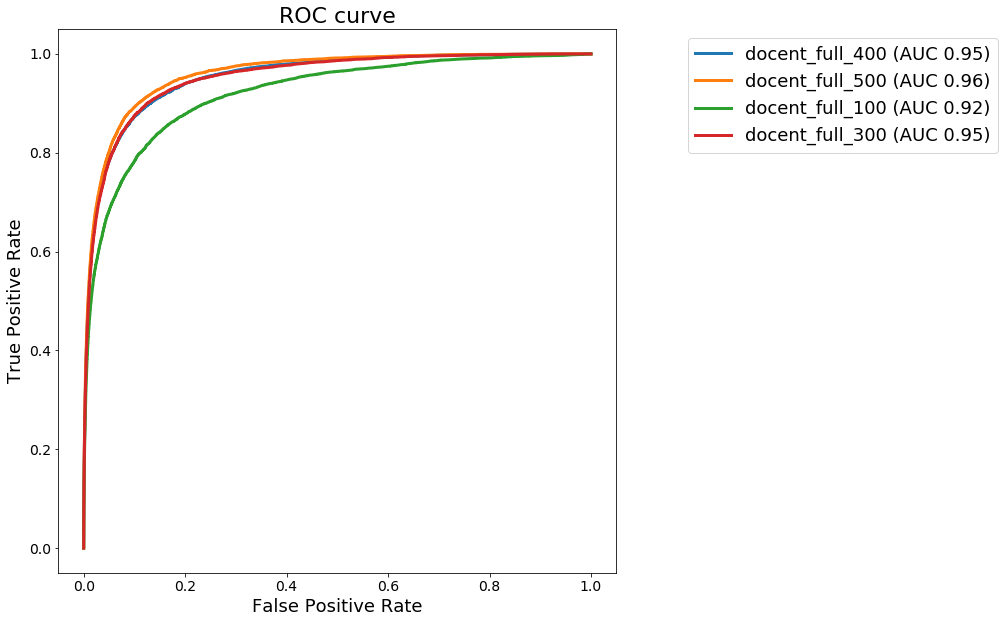

In [14]:
def plot_binary_results(results):    
    plt.figure(figsize=(10, 10))#, dpi=400)
    ax = plt.subplot(1, 1, 1)
    for name, result in results.items():
        if "fpr" in result and "tpr" in result:
            ax.plot(result["fpr"], result["tpr"], label='%s (AUC %.2f)' % (name, result["auc"]), linewidth=3)
        
        plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1), fontsize=18)
        for tick in ax.get_xticklabels():
            tick.set_fontsize(14)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(14)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC curve', fontsize=22)
    plt.show()

plot_binary_results(results_movie_heldout)

In [15]:
class HumanScoresModel(object):
    def __init__(self, df, movie_vocab, tag_vocab):
        self.movies = np.arange(len(movie_vocab))
        self.tags = np.arange(len(tag_vocab))
        self.score = MovieLens.compute_user_score(df, movie_vocab, tag_vocab)
#         self.score /= (self.score.sum(axis=1, keepdims=True) + 1e-8)

def human_cv_eval(movielens, movie_vocab, tag_vocab, cv_num_folds, models=None, groundtruth_threshold=0):
    users = movielens.df.user.unique()
    assert cv_num_folds <= len(users)
    num_users_per_fold = int((len(users) + cv_num_folds - 1) / cv_num_folds)
    np.random.seed(31415)
    users_perm = np.random.permutation(len(users))

    all_folds_results = []
    for cv_step, i in enumerate(range(0, len(users), num_users_per_fold)):
        users_heldout = users[users_perm[i:min(i+num_users_per_fold, len(users))]]
    
        model = HumanScoresModel(
            df=movielens.df[~movielens.df.user.isin(users_heldout)].copy(),
            movie_vocab=movie_vocab,
            tag_vocab=tag_vocab,
        )
        labels = MovieLens.compute_user_score(
            movielens.df[movielens.df.user.isin(users_heldout)].copy(),
            movie_vocab=movie_vocab,
            tag_vocab=tag_vocab,
        )
        
        current_models = {
            'Human': model,
        }
        if models is not None:
            current_models.update(models)
        
        all_folds_results.append(eval_model(
            models=current_models,
            labels=labels,
            groundtruth_threshold=groundtruth_threshold)[0])
  
    models_names = ['Human']
    if models is not None:
        models_names.extend(models.keys())
    averaged_results = {}
    for model_name in models_names:
        allmetrics = set([
            metric            
            for current_fold_result in all_folds_results            
            for metric in current_fold_result[model_name].keys()

        ])    
        averaged_results[model_name] = dict()
        for metric in allmetrics:
            if metric in ["tpr", "fpr"]:
                continue
            averaged_results[model_name][metric] = np.stack([
                current_fold_result[model_name][metric]
                for current_fold_result in all_folds_results                
            ]).mean(axis=0)
    return averaged_results 

models = {
#     'TagGenome': genome_model,
#     'tf-idf': tf_idf_model,
}
models.update(docent_models)

results_movie_heldout_with_human = human_cv_eval(
    movielens=movielens,
    movie_vocab=movie_vocab,
    tag_vocab=tag_vocab,
    cv_num_folds=3,
    models=models,
    groundtruth_threshold=2,
)

--- Movies 6392, Tags 500
--- WARNING: There are 4759 movies without any labels (tags): 6,30,31,42,46,47,49,58,72,76,81,92,123,132,133,139,140,154,156,160,162,165,170,174,185,187,191,192,195,199,201,206,208,210,215,219,221,226,233,236,243,244,245,247,249,251,261,265,266,269,275,284,295,302,303,305,316,319,321,323,324,326,339,341,343,345,347,349,350,351,354,357,368,370,371,372,382,386,388,391,397,399,400,401,403,407,410,411,412,413,422,430,431,432,443,444,445,450,451,452,453,454,462,464,465,479,484,485,486,487,488,489,491,492,493,495,496,497,499,503,505,506,509,513,514,516,520,525,527,534,535,536,539,544,551,553,554,573,574,575,585,593,594,600,602,608,616,617,618,621,626,628,629,632,633,636,637,639,641,642,643,644,645,647,648,649,651,653,654,674,676,679,680,682,685,686,688,689,691,692,693,695,696,699,704,705,707,719,720,724,726,733,735,739,741,742,743,748,749,752,758,767,768,769,793,797,803,806,810,814,815,816,818,819,821,828,838,841,843,844,847,848,849,852,854,855,859,861,867,877,878,8

--- Model docent_full_400
--- Model docent_full_500
--- Model docent_full_100
--- Model docent_full_300
--- Movies 6392, Tags 500
--- WARNING: There are 4969 movies without any labels (tags): 6,27,30,31,34,46,47,49,57,58,62,63,76,77,93,99,113,123,132,133,139,140,156,160,162,170,174,181,185,187,191,195,196,199,201,208,209,210,213,215,216,219,222,226,233,236,242,247,249,261,265,266,269,275,284,285,295,301,302,305,316,318,319,321,324,325,335,339,341,343,344,345,347,349,350,351,354,357,370,371,372,382,399,400,401,403,413,421,422,426,430,431,432,441,443,449,451,453,454,464,465,466,479,484,485,486,488,489,490,491,492,493,495,496,497,502,505,506,507,509,511,513,514,515,516,520,525,527,534,535,536,538,539,540,541,543,545,554,567,573,574,575,578,579,586,587,588,594,597,600,601,603,608,616,617,625,626,627,628,629,631,632,635,636,637,639,641,642,643,644,645,646,647,648,649,653,666,674,676,679,680,682,684,685,686,687,688,690,691,692,693,694,695,696,699,704,705,706,707,719,720,723,724,725,726,733,7

--- Model docent_full_400
--- Model docent_full_500
--- Model docent_full_100
--- Model docent_full_300
--- Movies 6392, Tags 500
--- WARNING: There are 4892 movies without any labels (tags): 6,30,31,46,47,58,60,63,69,72,77,81,99,110,111,123,127,133,139,140,141,160,162,165,185,187,188,191,194,197,201,206,208,209,213,215,216,219,222,226,233,236,242,244,245,247,249,252,257,260,265,266,269,272,275,284,285,288,295,301,302,303,316,318,322,323,324,335,338,339,340,341,343,345,347,349,350,351,353,354,355,357,371,372,386,394,399,400,401,403,410,411,422,426,430,431,432,437,440,443,444,445,446,449,451,452,453,454,460,462,464,465,478,479,484,485,486,488,490,491,492,493,495,496,497,499,502,503,505,506,507,509,513,514,515,516,520,525,527,534,535,536,538,539,540,541,567,568,573,574,575,586,588,593,600,608,616,617,618,625,628,629,632,635,636,637,639,641,642,643,644,645,647,648,649,651,653,665,674,676,679,680,682,685,686,687,692,693,695,696,699,700,704,705,707,719,720,723,724,726,733,737,739,741,742,74

--- Model docent_full_400
--- Model docent_full_500
--- Model docent_full_100
--- Model docent_full_300


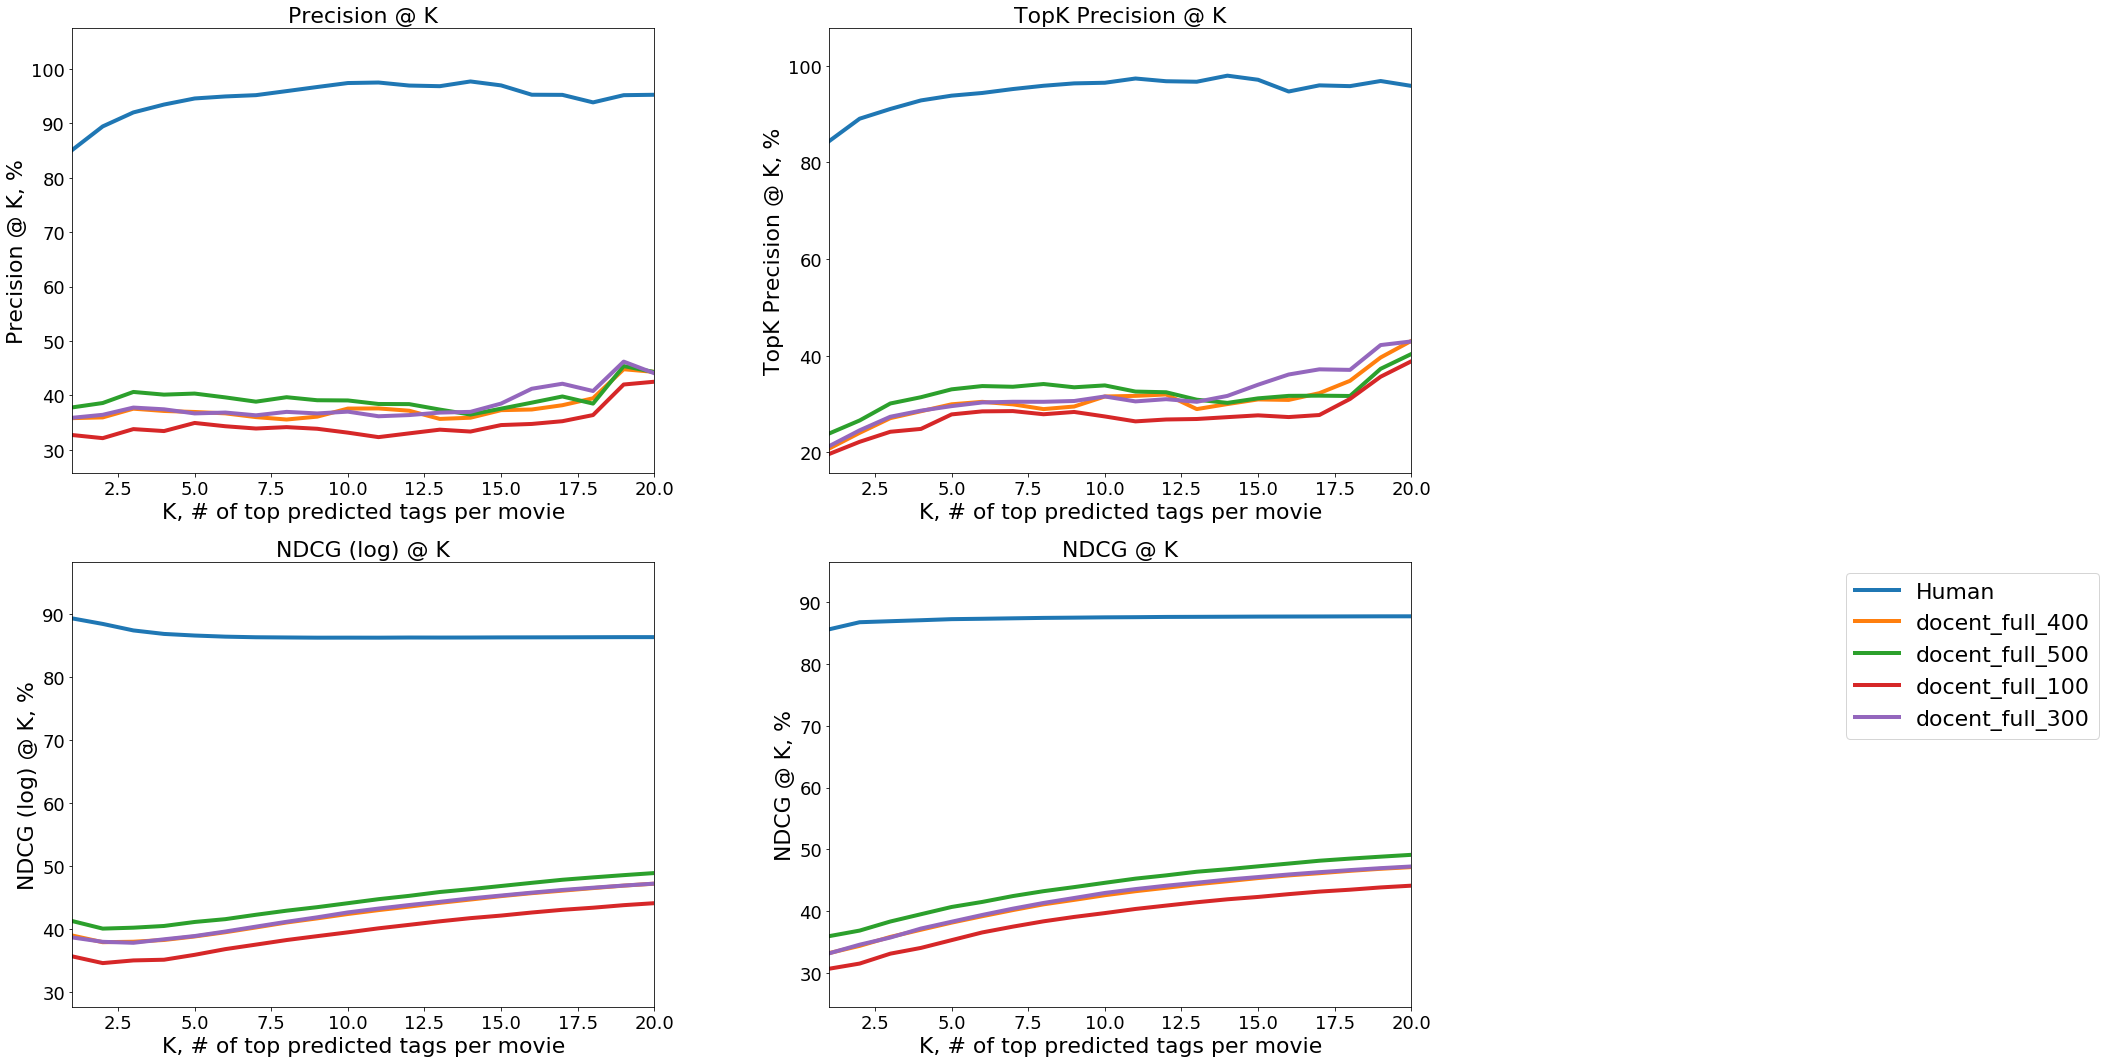

In [16]:
plot_ranking_results(results_movie_heldout_with_human)

In [17]:
print('Model\tMAP\tAUC')
print(
    '\n'.join(['%s\t%.1f\t%.2f' % (
        model,
        100.0 * results['mean_average_precision'],
        results['auc'])
        for model, results in sorted(results_movie_heldout_with_human.items())]
))

Model	MAP	AUC
Human	84.6	0.99
docent_full_100	34.0	0.93
docent_full_300	36.9	0.97
docent_full_400	36.6	0.97
docent_full_500	38.4	0.97
